# 1. Project Topic and Goal

GitHub Repo: https://github.com/wr0b1n/MSDS-5511-Week4

The Kaggle competition "Natural Language Processing with Disaster Tweets" focuses on using machine learning and NLP to predict whether a tweet is about a real disaster or not. The goal is to build a model that can classify tweets as either disaster-related or not. The provided dataset contains labeled tweets for training and a test set on which the model will be evaluated. For this purpose the F1 score is the metric set by the competition.

Natural Language Processing (NLP) is a special field in machine learning that focuses on teaching computers how to analyze and understand human language. It covers tasks such as segmenting text into words, recognizing certain emotions, or even language translation. NLP combines methods from machine learning and linguistics to create applications like chatbots and language translation tools. As with processing image data, text data requires its own specialized preprocessing steps, e.g. using techniques like tokenization which we will see later on.

# 2. Data

We have a CSV file for both the training and test data. Each file needs less than 1MB in disk space which es extremely small which is why we should not encounter any problems regarding large data sizes. Due to the CSV file type we can represent our data in a tabular format with several columns. The columns are:

* ID: a unique identifier for each tweet
* Keyword: a particular keyword from the tweet (may be blank)
* Location: the location the tweet was sent from (may be blank)
* Text: the text of the tweet
* Target: true labels 1 or 0 (only for training data) 


We will have a closer look at those during the EDA part. The Kaggle description already gives the hint that some values may be blank in the Keyword and Location column.

Additionally, there is a sample submission file showing us how our final submission file has to look like. We have to provide both the ID of the respective test tweet and the predicted label from our model. Our submission file will then be evaluated by Kaggle using the F1-score.

# 3. Import Python Libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Embedding, Bidirectional, GRU, Dense, Attention
from keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# 4. Inspecting our Dataset

## 4.1 EDA

We load all datasets and have a first view on them.

In [2]:
# read all data files
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
df_sample_sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_sample_sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


A first look at our data files shows that we have a training dataset that already contains a 'target' column with the true labels. A 1 means that the tweet is about a real disaster and 0 means it is not. Besides that, we have a test dataset that we will use for testing our models after predicting a certain label. We are also provided with a sample solution that shows us how our final solution has to look like. Each tweet ID from the test dataset has to match a predicted label. This file will then be uploaded to Kaggle where we can see our final score.

Now we will have a look at the word counts in the tweets. 

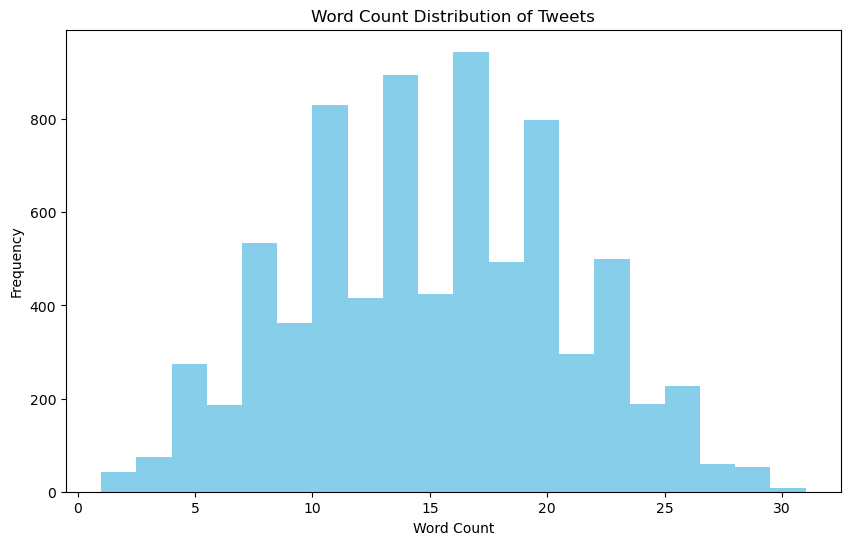

In [6]:
# calculate word count for each tweet and plot
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
plt.hist(df_train['word_count'], bins=20, color='skyblue')
plt.title('Word Count Distribution of Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

The word count distribution roughly follows a normal distribution without any remarkable outliers. Most of our tweets seem to consist of 10 up to 20 words. We can also have a look at the character count distribution.

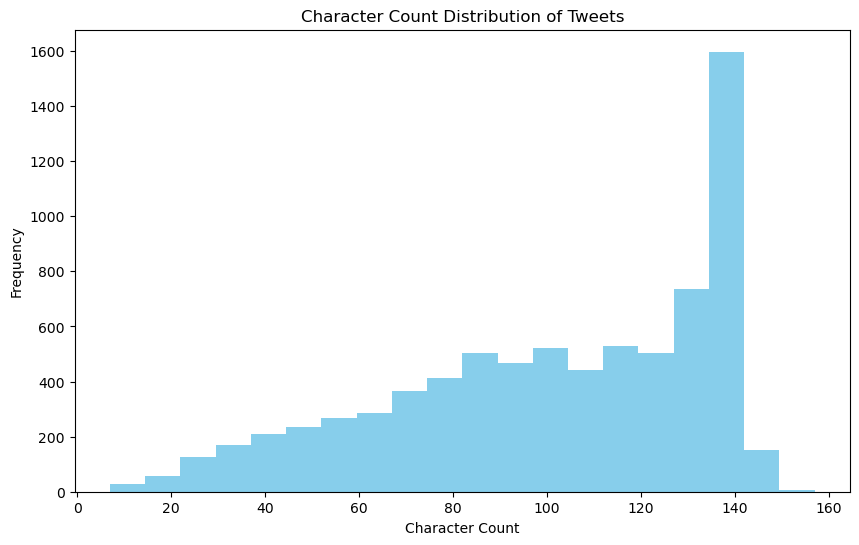

In [7]:
# calculate char count for each tweet and plot
df_train['char_count'] = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_train['char_count'], bins=20, color='skyblue')
plt.title('Character Count Distribution of Tweets')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

In contrast to the word count our character counts are not normally distributed. Most of the tweets seem to consist of around 140 characters.

Next we will check which words occur most often. Let's visualize this using a word cloud where words occuring more often are displayed larger.

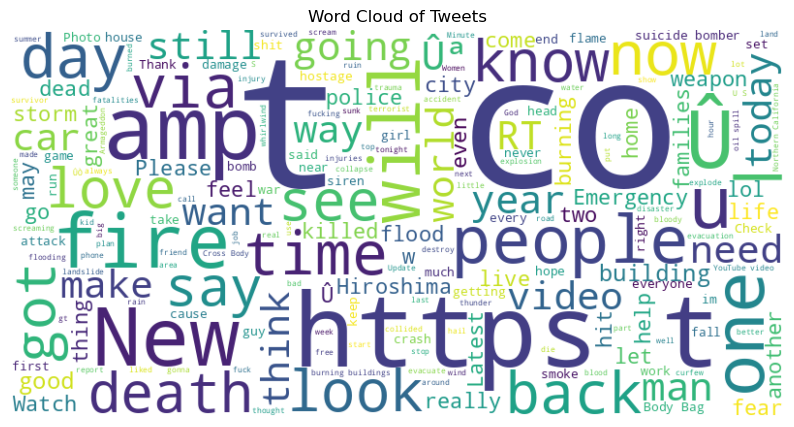

In [8]:
# combine all tweet strings
all_tweets = ' '.join(df_train['text'])

# create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

We recognize some words like "t" or "co" that seem to appear very often but may be meaningless. We will take care of these during the data cleaning part. Nevertheless, we can also see that there are indeed many words likely related to disasters like "fire" or "death".

Since it is quite important to have a balanced dataset before applying a classification model on our data we should check the label distribution of our training dataset.

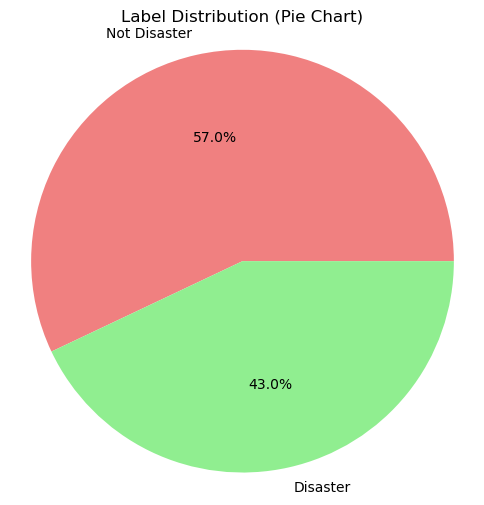

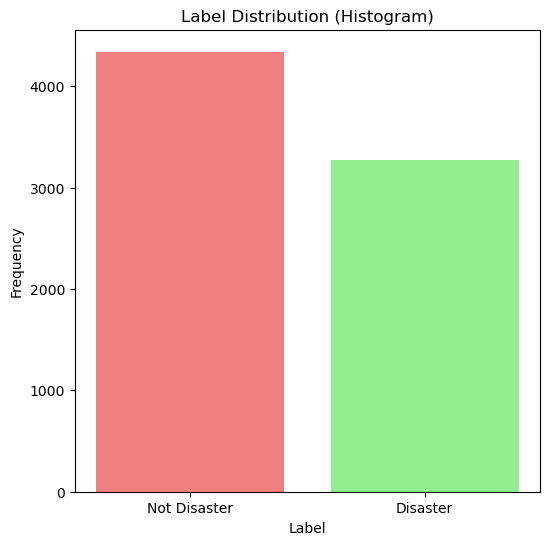

In [9]:
label_counts = df_train['target'].value_counts()

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Label Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

# histogram
plt.figure(figsize=(6, 6))
plt.bar(label_counts.index, label_counts.values, color=['lightcoral', 'lightgreen'])
plt.title('Label Distribution (Histogram)')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(label_counts.index, ['Not Disaster', 'Disaster'])
plt.show()

We see that we have a few more tweets labeled as "Not Disaster" than "Disaster". Since the imbalance is not as substantially we will not balance our dataset during this project. However, we should keep in mind that this could introduce some risk on our model to be biased.  

## 4.2 Data Cleaning

One thing we definitely want to take care of is the expansion of contractions. The dictionary with all available contractions of the english language is taken from Stackoverflow:

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

Expanding contractions helps tokenize text more accurately, as each word is treated as a separate entity. It can also help to avoid ambiguities. For example, the contraction "I'll" can mean "I will" or "I shall" depending on the context.

In [10]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expand_contractions(text, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

Additionally we want to remove some less important information from our tweets. This includes the punctuation which does not add anything meaningful to our model. Then we do not need stopwords of english language like "the" or "and" since they also do not represent important information when it comes to deciding whether some tweet is about a disaster or not. And since we already saw during EDA that we have some frequently occuring meaningless short words consisting of only 1 or 2 characters we remove words with less than 3 characters. The last step is to convert everything to lower case to have a uniformly looking tweet and better comparability between different tweets.

In [11]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    return ' '.join([i for i in text.split() if i not in STOPWORDS])

def remove_less_than(text, minNumberOfChars):
    return ' '.join([i for i in text.split() if len(i) >= minNumberOfChars])

def convert_to_lower(text):
    return text.lower()

We will apply these cleaning steps to both the training and test dataset.

In [12]:
text_before_cleaning = df_train['text'][42]

In [13]:
# clean training data
df_train['text'] = df_train['text'].apply(lambda text: expand_contractions(text))
df_train['text'] = df_train['text'].apply(lambda text: remove_punctuation(text))
df_train['text'] = df_train['text'].apply(lambda text: remove_stopwords(text))
df_train['text'] = df_train['text'].apply(lambda text: remove_less_than(text, 3))
df_train['text'] = df_train['text'].apply(lambda text: convert_to_lower(text))


# clean test data
df_test['text'] = df_test['text'].apply(lambda text: expand_contractions(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_punctuation(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_stopwords(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_less_than(text, 3))
df_test['text'] = df_test['text'].apply(lambda text: convert_to_lower(text))

In [14]:
text_after_cleaning = df_train['text'][42]

In [15]:
print("Text before cleaning: ", text_before_cleaning)
print("Text after cleaning: ", text_after_cleaning)

Text before cleaning:  Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??
Text after cleaning:  had awesome time visiting cfc head office ancop site ablaze thanks tita vida taking care


Let's have a look at the cleaned text by comparing it with its original version. We can see that our cleaning stage is working as expected and our texts are now in a pretty clean format and ready for the actual data preprocessing step.

# 5. Data Preprocessing and Plan of Analysis

Before we can feed our data into different models we have to perform some further data preprocessing. First, we'll perform tokenization on the cleaned text data, then explore different word embedding methods, and finally split the data into training and validation sets for use in a model like LSTM.

Tokenization is the process of breaking down a sequence of text into individual units (typically words) which are then called tokens. These tokens can be seen as the features for our models and help us work with a normalized and standardized text data.

In [16]:
df_train['tokens'] = df_train['text'].apply(lambda text: word_tokenize(text))
df_test['tokens'] = df_test['text'].apply(lambda text: word_tokenize(text))

Let's look at an example:

In [17]:
print("Clean text: ", df_train['text'][0])
print("Tokenized text: ", df_train['tokens'][0])

Clean text:  our deeds reason earthquake may allah forgive
Tokenized text:  ['our', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive']


This seems to be fine, but we still do not have the right format for model input. We have to make use of word embedding methods that are a type of word representation technique to represent words as continuous, dense vectors in a multi-dimensional space. These word vectors allow algorithms to understand and work with language data more effectively.

Commonly known embedding techniques are:

* One-Hot Encoding: This method represents words as binary vectors. It's simple but not very informative and often results in high-dimensional vectors especially when we have large vocabularies. Instead it is often used for representing categorical data with small amount of categories as numerical data. For text data it does not seem to be a good choice.

* Word2Vec: Word2Vec learns word embeddings by training a neural network on a large corpus of text. It generates dense, continuous-valued word vectors that even capture semantic relationships between words. Word2Vec can be used for various NLP scenarios but is more computationally expensive than a simple One-Hot Encoding.

* GloVe (Global Vectors for Word Representation): GloVe combines global word co-occurrence statistics to learn word representations. It's known for capturing both syntactic and semantic word relationships. GloVe embeddings are pre-trained on large corpora and can also be used for various NLP scenarios.


For this project, both Word2Vec and GloVe embeddings might be great choices whereas One-Hot Encoding is probably not a good choice. We will proceed using Word2Vec since it offers a good balance between capturing semantic relationships and still being computationally efficient.

In [18]:
# define Word2Vec model
word2vec_model = Word2Vec(df_train['tokens'].tolist(), vector_size=100, window=5, min_count=1, sg=0, workers=4)

# convert tokens to Word2Vec vectors
def tokens_to_vectors(tokens, word2vec_model):
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    return vectors

df_train['word2vec_vectors'] = df_train['tokens'].apply(lambda x: tokens_to_vectors(x, word2vec_model))
df_test['word2vec_vectors'] = df_test['tokens'].apply(lambda x: tokens_to_vectors(x, word2vec_model))

Now, let's split our training data into training and validation set.

In [19]:
X = df_train['word2vec_vectors'] 
y = df_train['target']           

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test['word2vec_vectors']

For all model building steps we will ignore the keyword and location columns since they can be blank and we want to keep it as simple as possible. As a first step we will build a basic LSTM model based on our Word2Vec embedding and perform a possible improvement afterwards by tuning some hyperparameters. Finally, we compare this model against an alternative model architecture. After selecting the best model based on training results we will predict the labels for our test dataset and create a submission file in order to see the final F1-score.

# 6. Model Building

Let's build a basic LSTM model. Upfront, we have to specify a maximum sequence length in order to perform a padding that will help us to create equally long vector representations of tweets with different lengths. As we saw during EDA the longest tweets in our training consist of around 30 words which is why we set the parameter to this exact value. 

In [20]:
max_sequence_length = 30
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
X_val_padded = pad_sequences(X_val, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

We will start with a reasonable choice for learning rate and batch size and see how it works. These two parameters will be tuned in a second step. The model architecture consists of two LSTM layers followed by a dense output layer. The first LSTM layer processes sequences and returns sequences, while the second LSTM layer processes the sequence and returns a single output per sequence. The model is optimized for binary classification tasks and makes use of an Adam optimizer.

In [21]:
def create_lstm_model(learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(128, input_shape=(max_sequence_length, word2vec_model.vector_size), return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=20, batch_size=32)

Epoch 1/20
191/191 [==============================] - 18s 68ms/step - loss: 0.6836 - accuracy: 0.5719 - val_loss: 0.6777 - val_accuracy: 0.5752
Epoch 2/20
191/191 [==============================] - 12s 61ms/step - loss: 0.6766 - accuracy: 0.5713 - val_loss: 0.6765 - val_accuracy: 0.5739
Epoch 3/20
191/191 [==============================] - 12s 61ms/step - loss: 0.6674 - accuracy: 0.5829 - val_loss: 0.6499 - val_accuracy: 0.6481
Epoch 4/20
191/191 [==============================] - 12s 61ms/step - loss: 0.6214 - accuracy: 0.6611 - val_loss: 0.5914 - val_accuracy: 0.6921
Epoch 5/20
191/191 [==============================] - 12s 62ms/step - loss: 0.6102 - accuracy: 0.6695 - val_loss: 0.5940 - val_accuracy: 0.6934
Epoch 6/20
191/191 [==============================] - 11s 60ms/step - loss: 0.5939 - accuracy: 0.6892 - val_loss: 0.5841 - val_accuracy: 0.6940
Epoch 7/20
191/191 [==============================] - 11s 60ms/step - loss: 0.5888 - accuracy: 0.6890 - val_loss: 0.5946 - val_accuracy:

In [38]:
def plot_training_results(history, model_name):   

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(12, 4))

    # plot training and talidation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title(model_name + ': Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title(model_name + ': Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

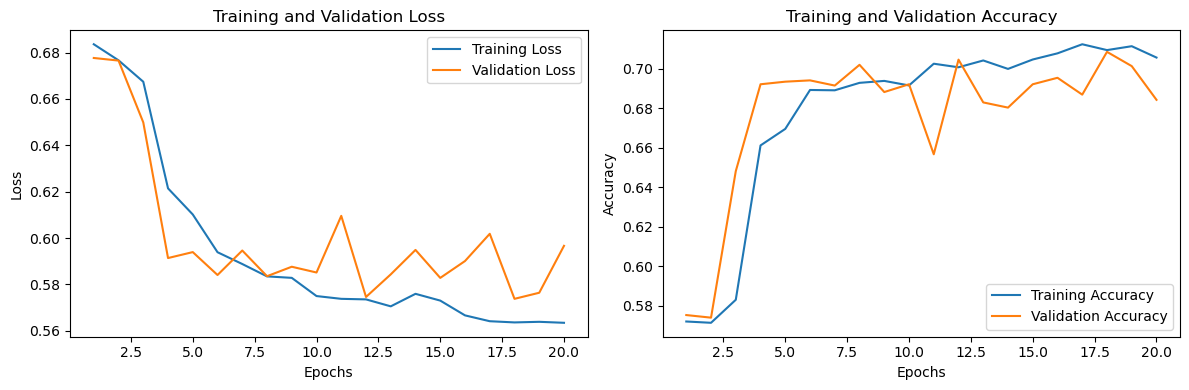

In [24]:
plot_training_results(lstm_history, "Basic LSTM")

We can see the expected increasing training accuracy over time respectively epochs while the loss is decreasing. After 20 epochs we get a training accuracy of around 70% which is not bad for a first try with this simple model! Let's see if we can improve by tuning some hyperparameters. Instead of using a predefined method like grid search we write our own logic since we only work with 2 hyperparameters.

In [25]:
# hyperparameters
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64, 128]

# global variables
best_accuracy = 0.0
best_learning_rate = None
best_batch_size = None
best_lstm_model = None
best_lstm_history = None

# iterate all parameter combinations
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        
        # train model
        model = create_lstm_model(learning_rate=learning_rate)
        history = model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=20, batch_size=batch_size, verbose=0)
        
        # evaluate model
        val_accuracy = model.evaluate(X_val_padded, y_val, verbose=0)[1]
                
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_learning_rate = learning_rate
            best_batch_size = batch_size
            best_lstm_model = model
            best_lstm_history = history

# print best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Batch Size: {best_batch_size}")
print(f"Best Validation Accuracy: {best_accuracy}")

Best Hyperparameters:
Learning Rate: 0.001
Batch Size: 128
Best Validation Accuracy: 0.700590968132019


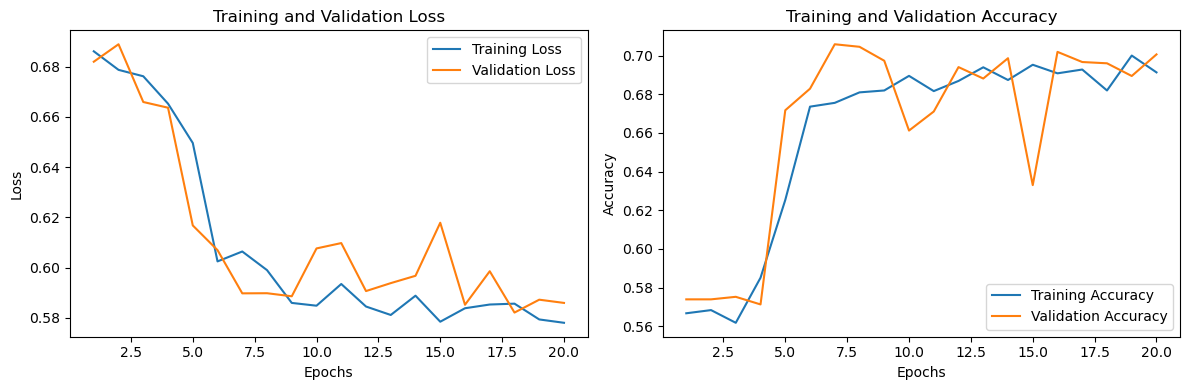

In [26]:
plot_training_results(best_lstm_history, "Tuned LSTM")

The hyperparameter tuning did not yield a significant improvement. The results are more or less the same as before. Maybe another model architecture will work better. For better comparability we will reuse the determined best learning rate and batch size from before.

We will work with a Bidirectional GRU (Gated Recurrent Unit) which is a type of RNN architecture that extends the capabilities of a standard GRU. It can process input sequences in both the forward and backward directions. This bidirectional processing allows the model to capture not only the context of each element in a sequence but also the context from both past and future elements. A simple LSTM on the other hand processes input sequences in only one direction, capturing context from the past.

In [27]:
embedding_dim = 100
hidden_units = 64

# iput layer
sequence_input = Input(shape=(max_sequence_length, embedding_dim), dtype='float32')

# bdirectional GRU layer
bi_gru = Bidirectional(GRU(hidden_units, return_sequences=True))(sequence_input)

# atention mechanism
attention = Attention()([bi_gru, bi_gru])
attended_gru = tf.keras.layers.Multiply()([bi_gru, attention])
pooling = tf.keras.layers.GlobalMaxPooling1D()(attended_gru)

# otput layer
output = Dense(1, activation='sigmoid')(pooling)

# ceate the model
bigru_model = Model(inputs=sequence_input, outputs=output)
optimizer = Adam(learning_rate=best_learning_rate)
bigru_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

bigru_history = bigru_model.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=20, batch_size=best_batch_size)

Epoch 1/20
48/48 [==============================] - 9s 94ms/step - loss: 0.6890 - accuracy: 0.5693 - val_loss: 0.6826 - val_accuracy: 0.5739
Epoch 2/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6851 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 3/20
48/48 [==============================] - 4s 75ms/step - loss: 0.6829 - accuracy: 0.5695 - val_loss: 0.6814 - val_accuracy: 0.5739
Epoch 4/20
48/48 [==============================] - 4s 77ms/step - loss: 0.6821 - accuracy: 0.5695 - val_loss: 0.6788 - val_accuracy: 0.5745
Epoch 5/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6803 - accuracy: 0.5759 - val_loss: 0.6745 - val_accuracy: 0.5772
Epoch 6/20
48/48 [==============================] - 4s 81ms/step - loss: 0.6726 - accuracy: 0.5846 - val_loss: 0.6631 - val_accuracy: 0.6100
Epoch 7/20
48/48 [==============================] - 4s 76ms/step - loss: 0.6642 - accuracy: 0.5970 - val_loss: 0.6559 - val_accuracy: 0.6225
Epoch 8/20
48

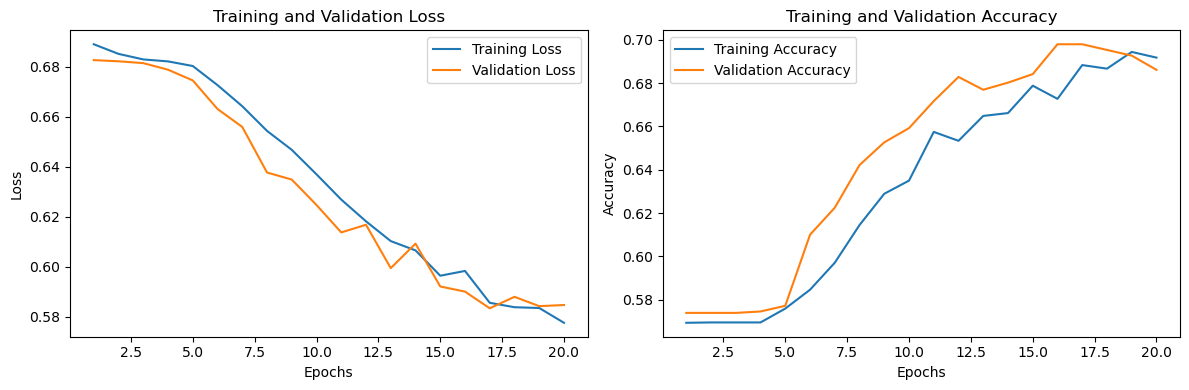

In [28]:
plot_training_results(bigru_history, "Bidirectional GRU")

The final results are nearly the same as with the (tuned) LSTM. However, the LSTM did converge faster to its plateau value. We will talk about these results in the next section in more detail.

# 7. Results and Analysis

In this section we want to summarize our findings during model building and decide which model we should use for predicting on the test data.

Let's have a look again at the training and result from our model.

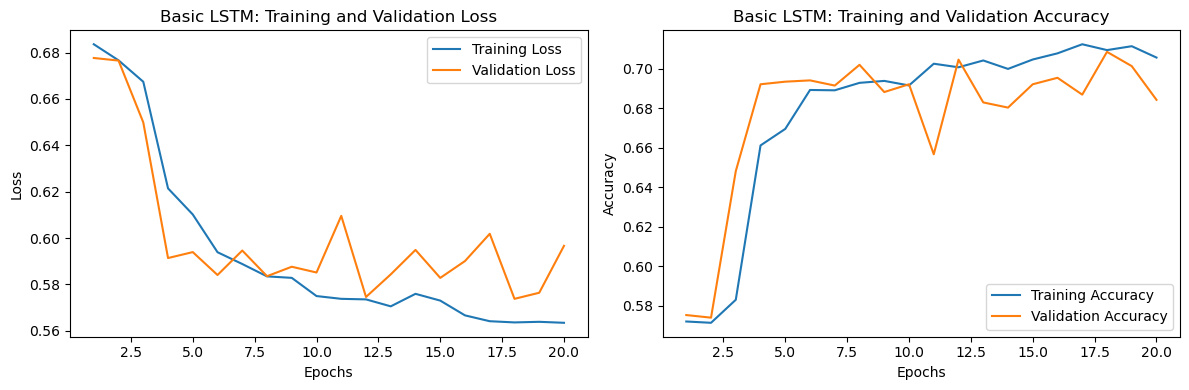

In [40]:
plot_training_results(lstm_history, "Basic LSTM")

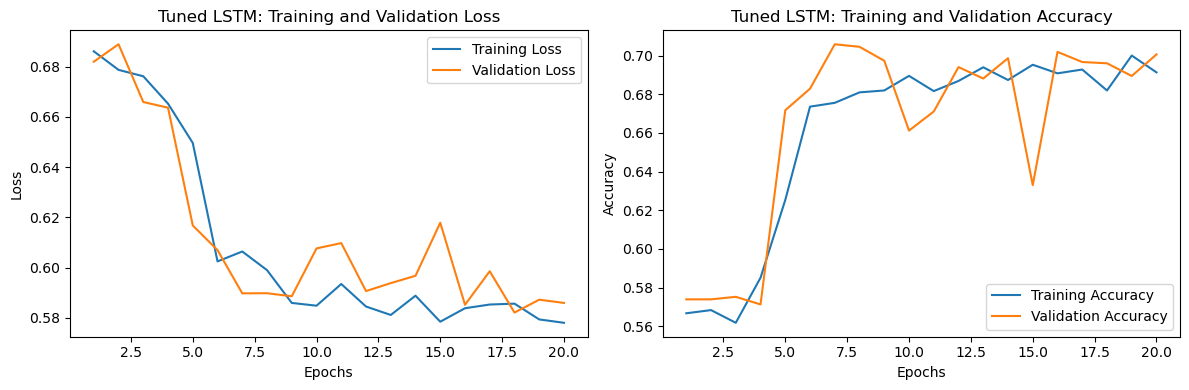

In [39]:
plot_training_results(best_lstm_history, "Tuned LSTM")

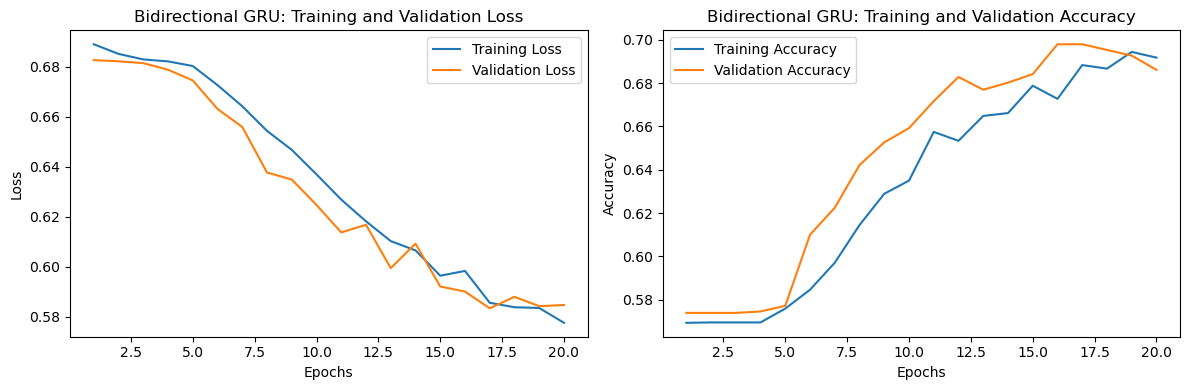

In [41]:
plot_training_results(bigru_history, "Bidirectional GRU")

Comparing all graphs side by side we actually see not much of a difference in training results. The tuning process did not seem to help much but just slightly. The bidirectional GRU even converged slower to the final accuracy score that is about the same as with the LSTM. Based on these results the tuned LSTM might be the best choice at this point.

There could be several reasons why the GRU model did not show any improvement over the LSTM model. For example, some tasks like ours, especially those with relatively short sequences or simple patterns, may not benefit significantly from bidirectional modeling. Additionally, we did not perform a tuning of hyperparameters with the GRU model which may helped in getting better results.

One thing I had some trouble with during training was the padding step before model training since I did not notice that all vectors are of different length and therefore need to be preprocessed in order to be executed properly. And of course one must choose a proper value for the length of the sequence which I were able to thanks to the preceding EDA steps.

The best hyperparameters choosen for the LSMT were:

In [42]:
# display best hyperparameters of LSTM model
learning_rates = [best_learning_rate]
batch_sizes = [best_batch_size]
validation_accuracies = [best_accuracy]  
df_results = pd.DataFrame({'Learning Rate': learning_rates, 'Batch Size': batch_sizes, 'Validation Accuracy': validation_accuracies})
print(df_results)

   Learning Rate  Batch Size  Validation Accuracy
0          0.001         128             0.700591


Now that we have decided on our best model, let's predict on the test data and create a submission file.

In [33]:
# predict on test data
y_pred = best_lstm_model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)
df_submission = pd.DataFrame({'id': df_test['id'], 'target': y_pred_binary.flatten()})
df_submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 3s 25ms/step


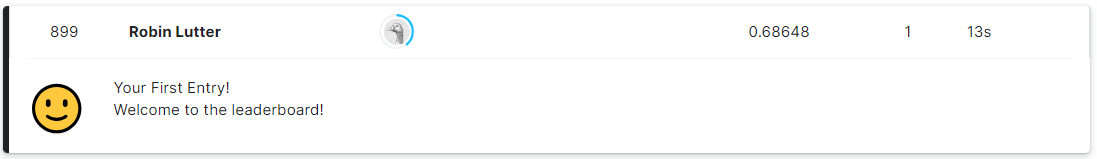

Uploading the submission file to Kaggle yields the final score alongside our position on the leaderboard as shown above. 

# 8. Conclusion

## 8.1 Result Summary

As we have seen we experimented with different models and selected the best one based on the training results to predict our test labels. Then we uploaded the submission file and got a solid score even so there is room for improvement.

## 8.2 Learnings and Takeaways

One of the main learnings and takeaways for me personally is the fact that there can be a significant amount of work and complexity when working the text data. Data cleaning alone can get very tedious if you want remove or replace all unimportant information. Additionally, there are many different methods for representing text data in order to enable models to work with it (e.g. word2vec). In conclusion there is much more work to do and knowledge needed compared to working with standard numerical data. 

## 8.3 What didn't work

As already seen in the results and analysis section we could not achieve significantly higher training scores after tuning our LSTM model or choosing an alternative architecture. Due to the nature of our data it might be reasonable that the GRU architecture was not a good choice and we should have tried some other model or put more work in the data preprocessing step. 

## 8.4 Possible improvements

There are several things that could be improved. Besides improving on the cleaning step, we could have balanced our dataset which helps training a model that is not biased toward the majority class using a method like oversampling. Additionally, we could include the keyword and location information to feed our model with more information in order to make hopefully more precise predictions. Other word embedding methods like GloVe might be an improvement as well.